In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool
import shap
from feature_mapping import map_feature

In [35]:
df_who_ref = pd.read_excel('../WHO_tables/bmi-boys-perc-who2007-exp.xlsx')

In [36]:
# Define the age range and convert it to months
age_years = list(range(7, 19))  # From 7 to 18 years inclusive
age_months = [age * 12 for age in age_years]

# Filter the dataset for the specified months and select relevant columns
filtered_df = df_who_ref[df_who_ref['Month'].isin(age_months)][['Month', 'P5', 'P15', 'P85', 'P95']]

# Map months back to years for clarity
filtered_df['Age'] = filtered_df['Month'] // 12
filtered_df = filtered_df.drop(columns=['Month'])

filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,P5,P15,P85,P95,Age
0,13.504,14.166,17.111,18.261,7
1,13.666,14.350,17.508,18.802,8
2,13.866,14.579,17.987,19.453,9
3,14.127,14.875,18.568,20.225,10
4,14.469,15.260,19.260,21.113,11
5,14.891,15.734,20.052,22.090,12
6,15.402,16.303,20.943,23.144,13
7,15.976,16.941,21.891,24.221,14
8,16.547,17.580,22.812,25.229,15
9,17.078,18.176,23.656,26.126,16


In [37]:
df_5 = pd.read_spss('../final_data/caspian-5.sav',convert_categoricals=True)
df_5.shape

(13983, 382)

In [38]:
df_5 = df_5.rename(columns=map_feature)

In [39]:
df_5.gender.unique()

['girl', 'boy']
Categories (2, object): ['boy', 'girl']

In [40]:
df_5 = df_5[df_5['gender']=='boy']


In [41]:
df_5 = df_5.drop(['var00001', 'univers0', 'region2', 'cluster2', 'cross2', 'sex2', 'birth_y0', 'sample_0'],axis=1)

In [42]:
df_5.shape

(7085, 374)

In [43]:
def preprocess(dataframes_dict):
    processed_dfs = {}  # Dictionary to store processed DataFrames
    for name, df_org in dataframes_dict.items():
        df = df_org.copy()
        df.replace('', np.nan, inplace=True)
        df.replace('?', np.nan, inplace=True)
        # Filter age
        df = df[(df["age"] >= 7) & (df["age"] <= 18)]

        # Convert height and weight to numeric
        df['height'] = pd.to_numeric(df['height'], errors='coerce')
        df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

        # Calculate BMI
        df["bmi1"] = df["weight"] / ((df["height"] / 100) ** 2)

        # Remove null tuples
        records_with_nulls = df[
            df["gender"].isna()
        ]
        df = df.dropna(subset=["gender"])
        missing_percent = df.isna().mean()
        threshold = 0.8
        df = df.loc[:, missing_percent <= threshold]

        # Fill missing values by grouping by age and using the mode
        for col in df.columns:
            if df[col].isna().any():  # Only process columns with missing values
                df[col] = df.groupby('age')[col].transform(
                    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
                )

        print(
            f"Number of records with NaN value in sex in {name}: {len(records_with_nulls)}"
        )

        # Store the processed DataFrame in the new dictionary
        processed_dfs[name] = df

    return processed_dfs

def calculate_percentile_labels(row, who_ref):
    """
    Categorizes BMI based on WHO reference percentiles for the corresponding age.
    """
    age = row['age']
    bmi = row['bmi1']
    
    # Filter WHO reference data for the specific age
    ref_data = who_ref[who_ref['Age'] == age]
    
    if ref_data.empty:
        return 'Unknown'  # Handle cases where reference data is not available
    
    # Extract the percentiles
    p5 = ref_data['P5'].values[0]
    p85 = ref_data['P85'].values[0]
    p95 = ref_data['P95'].values[0]
    
    # Categorize based on percentiles
    if bmi < p5:
        return 'Underweight'
    elif p5 <= bmi < p85:
        return 'Normal'
    elif p85 <= bmi < p95:
        return 'Overweight'
    else:
        return 'Obese'

def calculate_percentiles(processed_dfs, who_ref):
    """
    Adds a percentile category for each row based on WHO reference data.
    """
    for name_df, df_org in processed_dfs.items():
        df = df_org.copy()
        
        # Apply the function to calculate percentile categories
        df['bmi1_category'] = df.apply(
            lambda row: calculate_percentile_labels(row, who_ref), axis=1
        )
        
        # Update the processed DataFrame
        processed_dfs[name_df] = df

    return processed_dfs

input_dfs = {'casp5': df_5}  # Replace with your actual dataframe

# Preprocess the input data
processed_dataframes = preprocess(input_dfs)

# Use the WHO reference dataframe (df_who_ref)
final_dfs = calculate_percentiles(processed_dataframes, filtered_df)

# Save or output the final results
for name, df in final_dfs.items():
    print(f"Processed DataFrame for {name}:")
    print(df.head())

Number of records with NaN value in sex in casp5: 0
Processed DataFrame for casp5:
             id2   university region  cluster         grade gender  \
2   4.103118e+09      ardebil  urban      3.0     elemantry    boy   
3   5.011112e+10     lorestan  urban     11.0     elemantry    boy   
4   4.123522e+10    kurdestan  rural     35.0  intermidiate    boy   
9   4.114218e+09      ardebil  urban     14.0  intermidiate    boy   
10  3.104119e+09  azar gharbi  urban      4.0     elemantry    boy   

    birth_date  sample_c close_friend_count spent_time_friend1  ...   hp_98  \
2         80.0       1.0          3 or more              3 roz  ...  mother   
3         80.0       2.0          3 or more              0 roz  ...  father   
4         79.0       9.0          3 or more              2 roz  ...  mother   
9         77.0       6.0          3 or more              0 roz  ...  mother   
10        85.0      10.0          3 or more              2 roz  ...  mother   

   parental       hp_

In [55]:
def frequency_encode(df, categorical_columns):
    """
    Applies frequency encoding to the specified columns in the dataframe, filling null values with the mode based on each age group.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        columns (list): List of categorical columns to be frequency encoded.
        group_by_column (str): The column name to group by (default is 'age').

    Returns:
        pd.DataFrame: A dataframe with frequency-encoded columns.
    """
    df_encoded = df.copy()

    for col in categorical_columns:
        # Calculate the frequency for encoding after filling missing values
        if col != 'bmi1_category':
            frequency = df_encoded[col].value_counts() / len(df_encoded)
        
            # Apply frequency encoding
            df_encoded[col] = df_encoded[col].map(frequency)
            df_encoded[col] = pd.to_numeric(df_encoded[col])
        else:
            class_mapping = {'Underweight':0,'Normal':1,'Overweight':2,'Obese':3}
            df_encoded[col]=df_encoded[col].map(class_mapping)
            df_encoded[col] = pd.to_numeric(df_encoded[col])

    return df_encoded

# Example Usage
# Assuming 'df' is your dataframe
df = final_dfs['casp5']
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
df_encoded = frequency_encode(df, categorical_columns)

In [63]:
df_encoded['bmi1_category'].value_counts()

1    4381
0    1237
3     865
2     602
Name: bmi1_category, dtype: int64

/tmp/ipykernel_58003/796034743.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


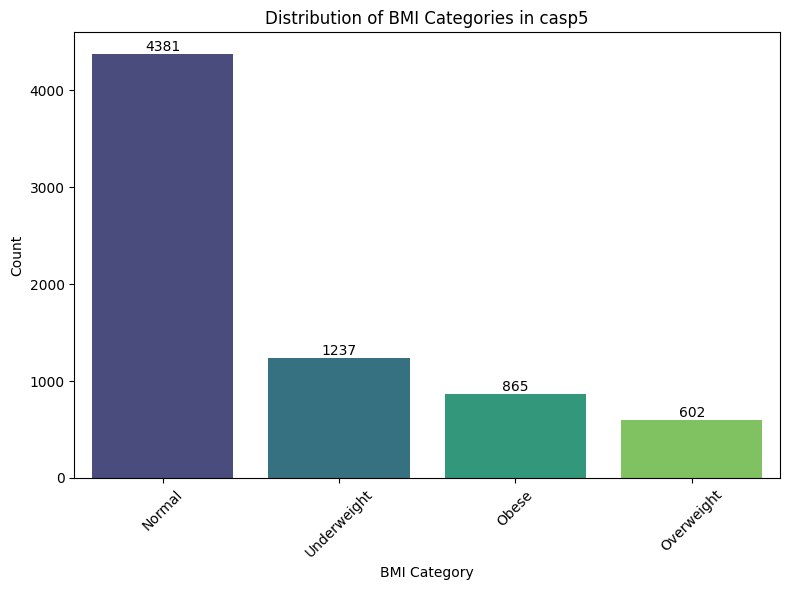

In [64]:
def plot_bmi_categories(processed_dfs, feature):
    for name, df in processed_dfs.items():
        # Count the occurrences of each category
        category_counts = df[f'{feature}_category'].value_counts()

        # Plot the counts
        plt.figure(figsize=(8, 6))
        ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')

        # Annotate counts above each bar
        for i, count in enumerate(category_counts.values):
            ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

        # Customize plot
        plt.title(f"Distribution of BMI Categories in {name}")
        plt.xlabel("BMI Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_bmi_categories(processed_dataframes,'bmi1')


In [ ]:
# Define functions
from collections import Counter
def split_X_y(df_org):
    df = df_org.copy()
    # print(f"Original class distribution:\n{df['bmi1_category'].value_counts()}")
    # unique_counts = df['bmi1_category'].value_counts().to_list()[-1]

    # class_2_samples = df[df['bmi1_category'] == 1]  # Filter rows where the label is 2
    # other_classes = df[df['bmi1_category'] != 1]   # Filter rows for other classes

    # # Randomly select 700 samples from class 2
    # selected_class_2 = class_2_samples.sample(n=unique_counts, random_state=42)

    # # Combine the selected samples from class 2 with other classes
    # balanced_df = pd.concat([selected_class_2, other_classes], ignore_index=True)

    # Reset the index of the resulting DataFrame
    # balanced_df = balanced_df.reset_index(drop=True)
    X = df.drop(columns=['weight', 'bmi1', 'id2', 'hip', 'neck', 'wrist', 'waist', 'cluster',
                          'catage', 'height','bmi1', 'bmi1_category','hp_101','body_image',
                          'hp_100','hp_101','hp_102','hp_103','hp_104','hp_105','birth_date'], axis=1)
    y = df['bmi1_category']
    print('X:',X.shape)
    print('y: ',y.shape)

    return X, y

def select_features(X, y, method, k=100, active=False):
    if active:
        selector = SelectKBest(method, k=k)
        selector.fit(X, y)
        return X.columns[selector.get_support()].tolist()
    else:
        return X.columns.tolist()

def train_catboost(X_train, y_train, iterations=100, random_state=42):
    model = CatBoostClassifier(
        iterations=iterations,
        random_seed=random_state,
        verbose=0
    )
    model.fit(X_train, y_train)
    return model, iterations

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return {"accuracy": accuracy, "report": report}

def process_and_train_model_for_each_age(final_dfs, catage, k=20):
    for name, df in final_dfs.items():
        results = []
        for cat in catage:
            # Filter dataset for the specific age
            df_age = df[df['catage'] == cat]
            
            if df_age.empty:
                continue

            X, y = split_X_y(df_age)
            
            # Resample the dataset
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
            class_counts = Counter(y_train)

            # Dynamic undersampling strategy
            undersample_target = min(class_counts.values())  # Don't add 100 here, or adjust accordingly
            sampling_strategy_under = {
                cls: min(undersample_target, count) if count > undersample_target else count
                for cls, count in class_counts.items()
            }
            
            oversample_target = max(sampling_strategy_under.values())  # Balance to the largest undersampled class
            sampling_strategy_over = {
                cls: max(oversample_target, count) if count < oversample_target else count
                for cls, count in sampling_strategy_under.items()
            }
            # Print dynamic strategies
            print(f"Original class distribution:\n{y_train.value_counts()}")
            print("Dynamic undersampling strategy:", sampling_strategy_under)
            print("Dynamic oversampling strategy:", sampling_strategy_over)

            # Define the pipeline
            resampling_pipeline = Pipeline([
                ('undersampler', RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=42)),
                ('smote', SMOTE(sampling_strategy=sampling_strategy_over, random_state=42))
            ])
            X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train, y_train)

            selected_features = select_features(X_resampled, y_resampled, f_classif, k=k, active=False)
            X_train_selected = X_resampled[selected_features]
            X_test_selected = X_test[selected_features]
            print(X_train_selected.shape)
            print(y_resampled.shape)

            catboost_model, iterations = train_catboost(X_train_selected, y_resampled)
            catboost_metrics = evaluate_model(catboost_model, X_test_selected, y_test)
            class_labels = catboost_model.classes_
            # Calculate feature importance
            feature_importance = catboost_model.get_feature_importance(prettified=False)
            explainer = shap.TreeExplainer(catboost_model)
            shap_values = explainer.shap_values(X)
            num_classes = shap_values.shape[-1]  # Number of classes (last dimension of SHAP values)
            print(catboost_metrics['accuracy'])
            for class_index in range(num_classes):
                print(f"Generating SHAP summary plot for class {class_labels[class_index]}")
                
                # Extract SHAP values for this class
                class_shap_values = shap_values[:, :, class_index]  # Shape: (4044, 343)
                # Plot SHAP summary for the selected class
                shap.summary_plot(class_shap_values, X, show=False)
                plt.title(f"SHAP Summary for Class {class_index}")
                plt.show()
            # Append results
            results.append({
                "catage": cat,
                "accuracy": catboost_metrics['accuracy'],
                "num_samples": len(df_age),
                "classification_report": catboost_metrics['report']
            })

        return results, shap_values, X_train_selected

input_dfs = {'casp5':df_encoded}
# Plot BMI category distribution
catage = df_encoded['catage'].unique()
# results = process_and_train_model_for_each_age(final_dfs,catage)
results,shap_values,X_train_selected = process_and_train_model_for_each_age(input_dfs,catage)

results_df = pd.DataFrame([{
"catage": r["catage"],
"accuracy": r["accuracy"],
"num_samples": r["num_samples"],
# "top_features": r["top_features"],
"classification_report": r["classification_report"]
} for r in results])

# results_df.to_csv("catage_based_model_results_boys_casp5.csv", index=False)
# print("Results saved to catage_based_model_results.csv.")

NameError: name 'df_encoded' is not defined

In [95]:
X_train_selected.shape

(544, 343)

In [93]:
results

[{'catage': 0.3913902611150318,
  'accuracy': 0.2918918918918919,
  'num_samples': 2773,
  'classification_report': {'0': {'precision': 0.2261904761904762,
    'recall': 0.4,
    'f1-score': 0.2889733840304182,
    'support': 95.0},
   '1': {'precision': 0.680672268907563,
    'recall': 0.23964497041420119,
    'f1-score': 0.3544857768052516,
    'support': 338.0},
   '2': {'precision': 0.11643835616438356,
    'recall': 0.3333333333333333,
    'f1-score': 0.17258883248730963,
    'support': 51.0},
   '3': {'precision': 0.21311475409836064,
    'recall': 0.36619718309859156,
    'f1-score': 0.2694300518134715,
    'support': 71.0},
   'accuracy': 0.2918918918918919,
   'macro avg': {'precision': 0.30910396384019584,
    'recall': 0.3347938717115315,
    'f1-score': 0.27136951128411274,
    'support': 555.0},
   'weighted avg': {'precision': 0.49121590240399765,
    'recall': 0.2918918918918919,
    'f1-score': 0.31567608680842174,
    'support': 555.0}}},
 {'catage': 0.2835568101623147